In [ ]:
# CELDA 0: Andamiaje completo de bootcamp IA (CV + NLP) en Drive
# -----------------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path
import textwrap
from datetime import date

# Ruta base en Drive
ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")

# Carpetas m√≠nimas
DIRS = [
    "data/raw",
    "data/processed",
    "models/cv",
    "models/nlp",
    "metrics/cv",
    "metrics/nlp",
    "notebooks",
    "src/cv",
    "src/nlp",
    "reports/figures",
]

for d in DIRS:
    (ROOT / d).mkdir(parents=True, exist_ok=True)

# README
readme = textwrap.dedent(f"""\
# M√≥dulo 4: Visi√≥n Artificial + PLN ‚Äì Bootcamp IA B√°sico
Fecha de creaci√≥n: {date.today().isoformat()}

Estructura m√≠nima para desarrollar dos modelos:
- Visi√≥n Artificial: clasificador de im√°genes.
- PLN: an√°lisis de sentimientos.

Instrucci√≥n: debes cargar tu dataset manualmente en `data/raw/`
""")
(ROOT / "README.md").write_text(readme, encoding="utf-8")

# requirements.txt
req = textwrap.dedent("""\
numpy
pandas
scikit-learn
matplotlib
tensorflow
torch
transformers
datasets
nltk
""")
(ROOT / "requirements.txt").write_text(req, encoding="utf-8")

# Archivos plantilla en src/
archivos = {
    "src/cv/preprocesamiento.py": '''"""
Preprocesamiento de im√°genes.
"""

def cargar_y_preprocesar_imagen(path_img):
    """Carga y transforma imagen individual."""
    pass  # TODO: usar PIL o tf.keras.utils.load_img()

def aplicar_aumentos(imagen):
    """Aumentos para entrenamiento."""
    pass  # TODO: usar keras.preprocessing o albumentations
''',

    "src/cv/modelo_base.py": '''"""
Modelo base CV con transferencia.
"""

def crear_modelo_transfer(num_clases):
    """Crea MobileNetV2 + capa final softmax."""
    pass  # TODO: tf.keras.applications.MobileNetV2
''',

    "src/nlp/limpieza_texto.py": '''"""
Limpieza b√°sica de texto.
"""

def limpiar(texto):
    """Limpia min√∫sculas, stopwords, signos."""
    pass  # TODO: usar re, nltk o spaCy
''',

    "src/nlp/modelo_sentimiento.py": '''"""
Modelo de sentimiento b√°sico.
"""

def crear_modelo_basico():
    """TF-IDF + regresi√≥n log√≠stica."""
    pass  # TODO: usar sklearn.pipeline
''',
}

# Guardar archivos plantilla
for ruta_rel, contenido in archivos.items():
    archivo = ROOT / ruta_rel
    archivo.parent.mkdir(parents=True, exist_ok=True)
    archivo.write_text(contenido, encoding="utf-8")

print(f"[ok] Estructura y archivos plantilla generados en:\n{ROOT}")


Mounted at /content/drive
[ok] Estructura y archivos plantilla generados en:
/content/drive/MyDrive/modulo_4_cv_nlp


# im√°genes
dandelion        1052
tulip             993
rose              784
daisy             764
sunflower         733

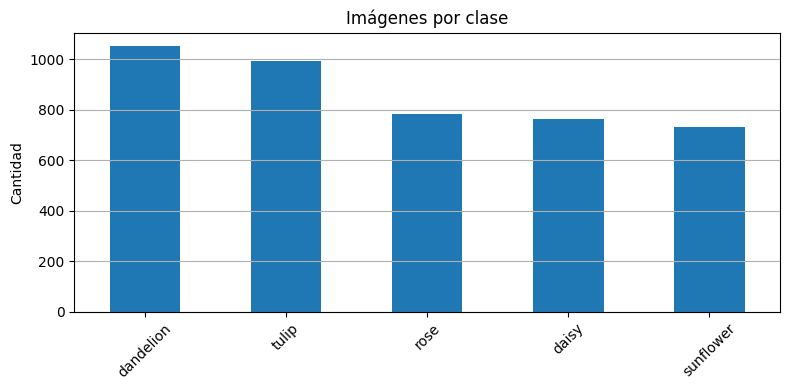

In [4]:
# CELDA 1: Verificaci√≥n del dataset manual en data/raw/flowers/
# -----------------------------------------------------------------------------------
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
RAW = ROOT / "data" / "raw" / "flowers"

# Verificar existencia
assert RAW.exists(), "No se encontr√≥ la carpeta: data/raw/flowers/"
clases = [d.name for d in RAW.iterdir() if d.is_dir()]
assert len(clases) >= 2, "Se necesitan al menos dos carpetas (clases) en flowers/"

# Contar im√°genes por clase
conteo = {}
for clase in clases:
    conteo[clase] = len(list((RAW / clase).glob("*.jpg")))

# Mostrar resumen
df = pd.DataFrame.from_dict(conteo, orient="index", columns=["# im√°genes"]).sort_values("# im√°genes", ascending=False)
display(df)

# Visualizaci√≥n gr√°fica
df.plot(kind="bar", figsize=(8,4), legend=False, title="Im√°genes por clase")
plt.xticks(rotation=45)
plt.ylabel("Cantidad")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [5]:
# CELDA 2: Split 80/20 y copia a data/processed/flowers/train|val/
# -----------------------------------------------------------------------------------
import shutil, random
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
RAW = ROOT / "data" / "raw" / "flowers"
PROC = ROOT / "data" / "processed" / "flowers"

# Configuraci√≥n
SPLITS = ["train", "val"]
FRAC_TRAIN = 0.8
EXT = [".jpg", ".jpeg", ".png"]
random.seed(42)

# Verificar dataset crudo
assert RAW.exists(), "Falta carpeta data/raw/flowers/"
clases = [d.name for d in RAW.iterdir() if d.is_dir()]
assert len(clases) >= 2, "Se necesitan al menos dos clases."

# Crear carpetas de salida
for split in SPLITS:
    for clase in clases:
        destino = PROC / split / clase
        destino.mkdir(parents=True, exist_ok=True)

# Procesar cada clase
for clase in clases:
    archivos = [p for p in (RAW / clase).glob("*") if p.suffix.lower() in EXT]
    random.shuffle(archivos)
    k = int(FRAC_TRAIN * len(archivos))
    train, val = archivos[:k], archivos[k:]

    for f in train:
        shutil.copy2(f, PROC / "train" / clase / f.name)
    for f in val:
        shutil.copy2(f, PROC / "val" / clase / f.name)

print(f"[ok] Divisi√≥n completada en {PROC}")


[ok] Divisi√≥n completada en /content/drive/MyDrive/modulo_4_cv_nlp/data/processed/flowers


Found 3459 files belonging to 5 classes.
Found 867 files belonging to 5 classes.


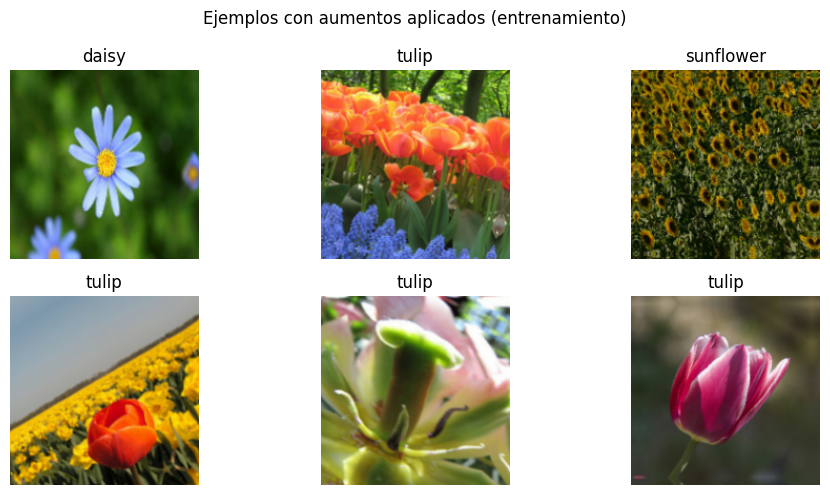

In [7]:
# CELDA 3 (ajustada): Cargar datos desde carpetas y aplicar aumentos con visualizaci√≥n
# -----------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Ruta base
ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
PROC = ROOT / "data" / "processed" / "flowers"

# Par√°metros de entrada
BATCH_SIZE = 32
IMG_SIZE = (180, 180)
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# ========================
# 1. Cargar datasets
# ========================

# Paso 1: Cargar train sin transformar para extraer nombres de clase
_raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PROC / "train",
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

class_names = _raw_train_ds.class_names

# Paso 2: Transformar (cache, shuffle, prefetch)
train_ds = _raw_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Paso 3: Validaci√≥n (sin shuffle)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PROC / "val",
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).cache().prefetch(buffer_size=AUTOTUNE)

# ========================
# 2. Aumentos de entrenamiento
# ========================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="image_augmentation")

# ========================
# 3. Visualizaci√≥n de ejemplos aumentados
# ========================
for images, labels in _raw_train_ds.take(1):
    augmented = data_augmentation(images)
    plt.figure(figsize=(10, 5))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(tf.cast(augmented[i], tf.uint8))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
    plt.suptitle("Ejemplos con aumentos aplicados (entrenamiento)")
    plt.tight_layout()
    plt.show()


#  ¬øQu√© es `ImageDataGenerator` y por qu√© es importante?

`ImageDataGenerator` es una clase de **Keras** que permite:

- **Cargar im√°genes desde carpetas** autom√°ticamente, organizadas por clase.
- **Preprocesarlas en tiempo real**: escalado, rotaci√≥n, zoom, recorte, etc.
- **Aplicar aumentos de datos** (*data augmentation*): simula m√°s datos a partir de los mismos ejemplos.

## ¬øPor qu√© es importante en Visi√≥n por Computador?

En tareas de clasificaci√≥n de im√°genes:

- **Los modelos de IA son sensibles a sobreajuste** cuando hay pocos datos.
- El `ImageDataGenerator` ayuda a generar variaciones **realistas** (como girar o voltear una flor).
- Esto mejora la **capacidad de generalizaci√≥n** del modelo.

## Beneficios

- Aumenta la **robustez** del modelo.
- Mejora el **rendimiento** con pocos datos.
- Simplifica la carga y etiquetado de im√°genes desde carpetas.

---
**Alternativa moderna** (m√°s usada en TF >=2.3):  
```python
tf.keras.utils.image_dataset_from_directory(...)

In [8]:
# CELDA 4: Definir modelo MobileNetV2 + entrenamiento
# -----------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path

# Ruta para guardar modelo
ROOT = Path("/content/drive/MyDrive/modulo_4_cv_nlp")
MODEL_DIR = ROOT / "models" / "cv"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ========================
# 1. Modelo base
# ========================

# Cargar MobileNetV2 sin la capa final (include_top=False)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # congelar pesos

# Aumento y preprocesamiento + clasificador
inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

# ========================
# 2. Compilar modelo
# ========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ========================
# 3. Entrenamiento
# ========================
EPOCHS = 5  # Puedes aumentar si deseas m√°s rendimiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# ========================
# 4. Guardar modelo entrenado
# ========================
model_path = MODEL_DIR / "mobilenetv2_flowers.h5"
model.save(model_path)
print(f"[ok] Modelo guardado en: {model_path}")


/tmp/ipython-input-2464723034.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_2 (InputLayer)      ‚îÇ (None, 180, 180, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ true_divide (TrueDivide)        ‚îÇ (None, 180, 180, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ subtract (Subtract)             ‚îÇ (None, 180, 180, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ mobilenetv2_1.00_224            ‚îÇ (None, 6, 6, 1280)     ‚îÇ     2,257,984 ‚îÇ
‚îÇ (Functional)                    ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 5)              ‚îÇ         6,405 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
109/109 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 152s 1s/step - accuracy: 0.5638 - loss: 1.0880 - val_accuracy: 0.8270 - val_loss: 0.4761
Epoch 2/5
109/109 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 117s 1s/step - accuracy: 0.8385 - loss: 0.4695 - val_accuracy: 0.8443 - val_loss: 0.4169
Epoch 3/5
109/109 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 109s 1s/step - accuracy: 0.8515 - loss: 0.4126 - val_accuracy: 0.8454 - val_loss: 0.4024
Epoch 4/5
109/109 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 142s 995ms/step - accuracy: 0.8766 - loss: 0.3334 - val_accuracy: 0.8570 - val_loss: 0.3673
Epoch 5/5
109/109 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 109s 1s/step - accuracy: 0.8963 - loss: 0.2920 - val_accuracy: 0.8616 - val_loss: 0.3519


[ok] Modelo guardado en: /content/drive/MyDrive/modulo_4_cv_nlp/models/cv/mobilenetv2_flowers.h5


# Modelo base: MobileNetV2 para clasificaci√≥n de im√°genes

## ¬øQu√© es MobileNetV2?

`MobileNetV2` es una arquitectura de red neuronal convolucional **ligera y eficiente**, dise√±ada para usarse en dispositivos con recursos limitados como celulares, c√°maras o microcontroladores.

- Fue desarrollada por Google (2018).
- Usa bloques llamados *depthwise separable convolutions*, que reducen el n√∫mero de par√°metros.
- Tiene buen rendimiento en tareas de visi√≥n, con bajo costo computacional.

## ¬øPor qu√© lo usamos aqu√≠?

Porque queremos **entrenar r√°pido** sin necesidad de construir una red desde cero, y aprovechamos que ya fue **preentrenada en ImageNet** (con millones de im√°genes reales).

## ¬øQu√© hicimos en este proyecto?

1. **Cargamos MobileNetV2 sin su capa final** (`include_top=False`), para usarla como extractor de caracter√≠sticas.
2. **Congelamos sus pesos**, para no reentrenar la parte convolucional (m√°s r√°pido).
3. **Agregamos una capa de clasificaci√≥n final**:
   - `GlobalAveragePooling2D`: reduce la salida de la red a un vector.
   - `Dropout`: evita sobreajuste.
   - `Dense(softmax)`: predice probabilidades para cada clase.

## ¬øC√≥mo se entrena?

Solo se entrena la "cabeza" del modelo (clasificador final). Esto se llama **transfer learning**.

## ¬øD√≥nde se usa en la vida real?

- Clasificaci√≥n de productos en supermercados.
- Identificaci√≥n de plantas, animales, objetos en apps m√≥viles.
- C√°maras inteligentes para seguridad o monitoreo.
- Proyectos en Edge AI (visi√≥n por computador en dispositivos f√≠sicos).

---
Usar modelos preentrenados acelera el desarrollo y reduce el consumo de recursos.



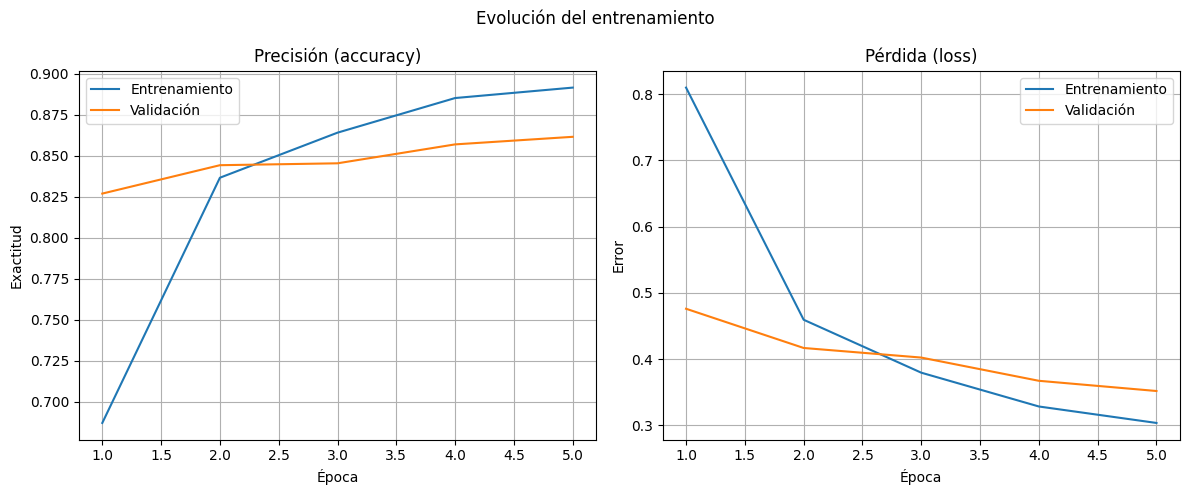

In [9]:
# CELDA 5: Gr√°ficas de rendimiento por √©poca
# -----------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Extraer historial
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

# Gr√°fica de accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Entrenamiento")
plt.plot(epochs_range, val_acc, label="Validaci√≥n")
plt.title("Precisi√≥n (accuracy)")
plt.xlabel("√âpoca")
plt.ylabel("Exactitud")
plt.legend()
plt.grid(True)

# Gr√°fica de loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Entrenamiento")
plt.plot(epochs_range, val_loss, label="Validaci√≥n")
plt.title("P√©rdida (loss)")
plt.xlabel("√âpoca")
plt.ylabel("Error")
plt.legend()
plt.grid(True)

plt.suptitle("Evoluci√≥n del entrenamiento")
plt.tight_layout()
plt.show()


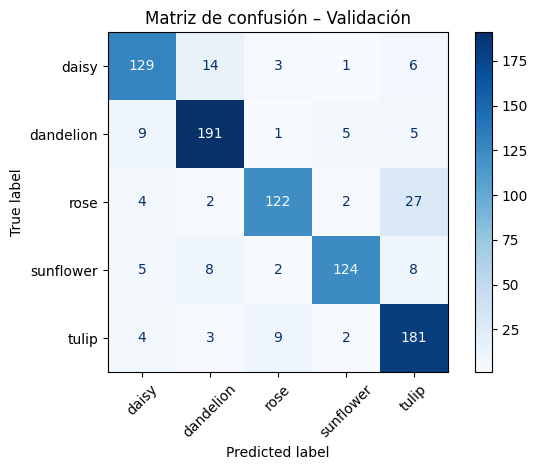

[ok] M√©tricas guardadas en: /content/drive/MyDrive/modulo_4_cv_nlp/metrics/cv/metrics_val.csv


In [10]:
# CELDA 6: Evaluaci√≥n, matriz de confusi√≥n y exportaci√≥n de m√©tricas
# -----------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

# 1. Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Reporte de clasificaci√≥n
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)
df_report = pd.DataFrame(report).transpose()

# 3. Matriz de confusi√≥n
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusi√≥n ‚Äì Validaci√≥n")
plt.tight_layout()
plt.show()

# 4. Guardar m√©tricas en CSV
metrics_path = Path("/content/drive/MyDrive/modulo_4_cv_nlp/metrics/cv/metrics_val.csv")
df_report.to_csv(metrics_path, index=True)
print(f"[ok] M√©tricas guardadas en: {metrics_path}")


### üîß Celda 7 (Opcional): *Fine-tuning* de MobileNetV2

Una vez entrenado el modelo base con capas congeladas, es posible aplicar una fase adicional llamada **fine-tuning**. Esta t√©cnica consiste en "descongelar" algunas capas internas del modelo preentrenado para permitir que se ajusten espec√≠ficamente a nuestro conjunto de datos.

#### ¬øPor qu√© hacer *fine-tuning*?
- El modelo base (MobileNetV2) fue entrenado con im√°genes gen√©ricas (ImageNet).
- Nuestro dominio espec√≠fico (flores u otra categor√≠a) puede beneficiarse de refinar las representaciones internas.
- Si tenemos m√°s datos o usamos data augmentation, podemos afinar sin sobreajustar.

#### ¬øQu√© se hace en esta fase?
- Se cargan los pesos previamente entrenados.
- Se descongelan capas profundas seleccionadas del modelo base.
- Se entrena nuevamente con una tasa de aprendizaje m√°s baja.
- Se guarda un nuevo modelo ajustado (`mobilenetv2_finetuned.h5`).

> Recomendado solo si tienes tiempo de entrenamiento suficiente y datos variados.  
> No es obligatorio para un prototipo funcional.



# ¬øPara qu√© sirve este modelo de clasificaci√≥n de im√°genes?

Este proyecto es una versi√≥n simplificada de los sistemas reales de visi√≥n artificial que se usan en muchas industrias. Al entrenar un modelo que reconoce im√°genes (por ejemplo, distintos tipos de flores), aprendiste a implementar un flujo b√°sico pero completo de reconocimiento visual con IA.

## üåç Aplicaciones reales

- **Agricultura inteligente**: detectar enfermedades en plantas, clasificar tipos de cultivos o flores autom√°ticamente a partir de im√°genes.
- **Comercio electr√≥nico**: identificar productos por foto para cat√°logos o b√∫squeda visual (ej: subir una flor y ver opciones de compra similares).
- **Medicina**: analizar im√°genes m√©dicas (como radiograf√≠as) para identificar patrones o clasificaciones relevantes.
- **Seguridad**: reconocimiento de objetos o personas en c√°maras de vigilancia, o inspecci√≥n visual automatizada en procesos industriales.

## Habilidades que se desarrollaron

- Preprocesamiento y carga de datos visuales
- Uso de modelos preentrenados (MobileNetV2)
- Transfer learning
- Entrenamiento, evaluaci√≥n y guardado de modelos
- Organizaci√≥n estructurada del proyecto (datasets, m√©tricas, c√≥digo, modelos)
- Reproducibilidad con `README` y `requirements.txt`

---

**En resumen:** este tipo de sistema te permite resolver problemas visuales reales. Aprenderlo te da las bases para crear soluciones en m√∫ltiples sectores que usan im√°genes como insumo principal.
